In [21]:
from cpymad.madx import Madx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from pybt.tools.plotters import *
from matplotlib.patches import Ellipse, Rectangle
import requests
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ezdxf import recover
from ezdxf.addons.drawing import RenderContext, Frontend
from ezdxf.addons.drawing.matplotlib import MatplotlibBackend
from ezdxf.addons.drawing.config import Configuration, BackgroundPolicy

from t07_functions import *

In [22]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
### GEODE ###

# Loading data
dev_f61 = pd.read_csv('geode_data/beam_dev_18_11_2021_F61.csv', skiprows=1)
dev_pr = pd.read_csv('geode_data/beam_dev_18_11_2021_PR.csv', skiprows=1)
dev_t08 = pd.read_csv('geode_data/beam_dev_18_11_2021_T08.csv', skiprows=1)
dev_t09 = pd.read_csv('geode_data/beam_dev_18_11_2021_T09.csv', skiprows=1)
dev_t10 = pd.read_csv('geode_data/beam_dev_18_11_2021_T10.csv', skiprows=1)
dev_t11 = pd.read_csv('geode_data/beam_dev_18_11_2021_T11.csv', skiprows=1)
dev_f62 = pd.read_csv('geode_data/beam_dev_18_11_2021_F62.csv', skiprows=1)
dev_f63 = pd.read_csv('geode_data/beam_dev_18_11_2021_F63.csv', skiprows=1)

df_f61 = calc_absolute_deviation(dev_f61)
df_pr = calc_absolute_deviation(dev_pr)
df_t08 = calc_absolute_deviation(dev_t08)
df_t09 = calc_absolute_deviation(dev_t09)
df_t10 = calc_absolute_deviation(dev_t10)
df_t11 = calc_absolute_deviation(dev_t11)
df_f62 = calc_absolute_deviation(dev_f62)
df_f63 = calc_absolute_deviation(dev_f63)

# Rotation parameters for GEODE
angle_degrees = 7.8
center_of_rotation = (2000, 2100)  # Example center (cx, cy)

for df in [df_f61, df_pr, df_t08, df_t09, df_t10, df_t11, df_f62, df_f63]:
    # Apply rotation to specific row
    for i in df.index:
        x_rotated, y_rotated = rotate_around_point(df.loc[i, 'x'], df.loc[i, 'y'], *center_of_rotation, angle_degrees)
        df.loc[i, 'x'] = x_rotated
        df.loc[i, 'y'] = y_rotated

In [23]:
p, exn, eyn, betx0, bety0, alfx0, alfy0, Dx0, Dy0, Dpx0, Dpy0, ex, ey, sige = calc_initial_condition(0.5)

4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c


In [24]:
# Calculate the MAD-X lattices
survey_f61d = f61d(p, exn, eyn, betx0, bety0, alfx0, alfy0, Dx0, Dy0, Dpx0, Dpy0)
survey_f61t8 = t8(p, exn, eyn, betx0, bety0, alfx0, alfy0, Dx0, Dy0, Dpx0, Dpy0)
survey_f61t07 = t07(p, exn, eyn, betx0, bety0, alfx0, alfy0, Dx0, Dy0, Dpx0, Dpy0)

# Translate and rotate the MAD-X surveys
df_survey_f61d_translated = translate_rotate(survey_f61d)
df_survey_f61t8_translated = translate_rotate(survey_f61t8)
df_survey_f61t07_translated = translate_rotate(survey_f61t07)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


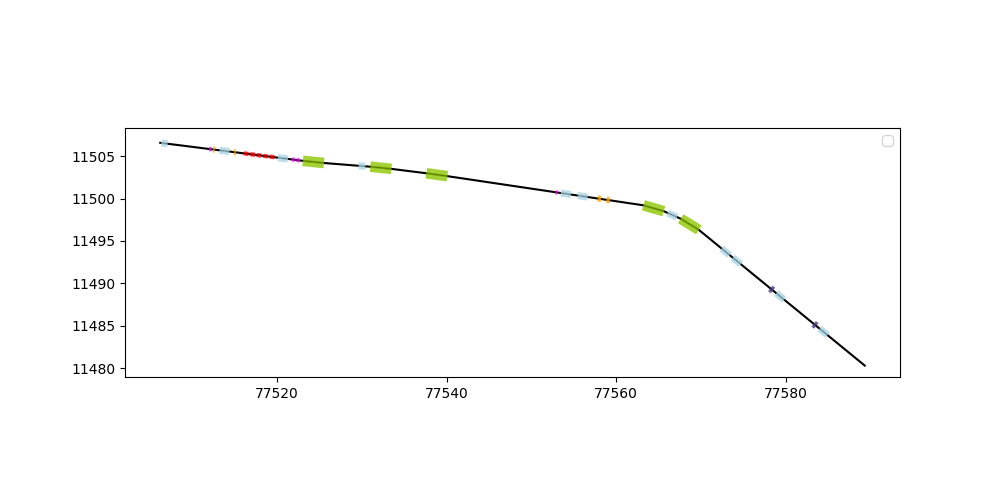

In [25]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(df_survey_f61t07_translated['x_rot'], df_survey_f61t07_translated['y_rot'], color='k',)
plot_magnets(df_survey_f61t07_translated, 'x_rot', 'y_rot', ax)

ax.legend()
ax.set_aspect('equal')

# ax.set_xlim(77520, 77550)
# ax.set_ylim(11506, 11515)

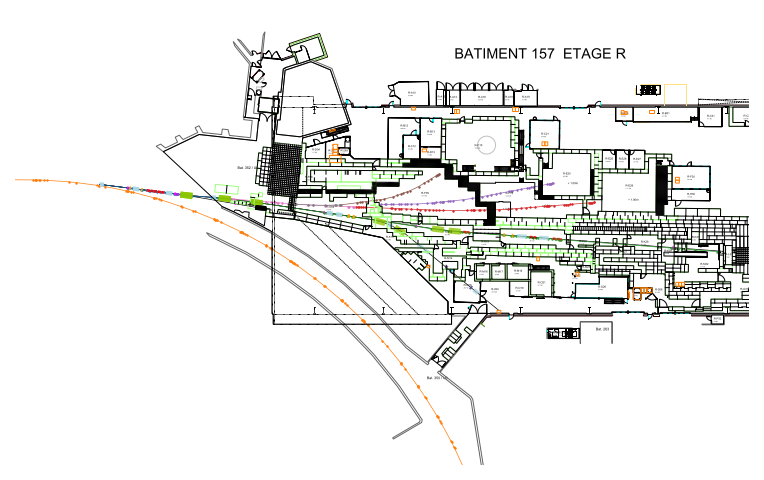

In [26]:
%matplotlib widget
plot_true = True
if plot_true:
    x_change_ref = 75490
    y_change_ref = 9309.75

    survey_f61t07 = t07(p, exn, eyn, betx0, bety0, alfx0, alfy0, Dx0, Dy0, Dpx0, Dpy0)
    df_survey_f61t07_translated = translate_rotate(survey_f61t07)

    fig, ax = plt.subplots(figsize=(50,10), tight_layout=True)
    doc, auditor = recover.readfile('157_R.dxf')
    ctx = RenderContext(doc)
    out = MatplotlibBackend(ax)

    config = Configuration().with_changes(background_policy=BackgroundPolicy.CUSTOM, custom_bg_color="#ffffff00", lineweight_scaling=1)

    frontend = Frontend(ctx, out, config=config)
    frontend.draw_layout(doc.modelspace(), finalize=True)

    for df in [df_f61, df_pr, df_t08, df_t09, df_t10, df_t11, df_f62, df_f63]:
        ax.plot(x_change_ref + df.x, y_change_ref + df.y, marker="+",zorder=99, markersize=2, linewidth=0.5)

    for df in [df_survey_f61d_translated, df_survey_f61t8_translated]:
        ax.plot(df['x_rot'], df['y_rot'], color='k', lw=0.5)
        plot_magnets(df, 'x_rot', 'y_rot', ax)

    for df in [df_survey_f61t07_translated]:
        ax.plot(df['x_rot'], df['y_rot'], color='k', lw=0.5)
        plot_magnets(df, 'x_rot', 'y_rot', ax)

    xmin = 77490
    xmax = 77640
    ymin = 11490
    ymax = 11500

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    ax.set_aspect("equal")
    fig.savefig('images/East_Area_combined_survey.png', dpi=800)

In [7]:
from madxtools.math import *
max_field = 1.5 # Tesla
dipole_length = 2.5 # m
max_ekin = 0.5 # GeV/u
print(f"Max angle is {round(max_field*dipole_length/pb_ion_rigidity(max_ekin),3)}")

Max angle is 0.269


In [8]:
from madxtools.math import *
max_field = 1.5 # Tesla
dipole_length = 2.5 # m
max_ekin = 2.0 # GeV/u
print(f"Max angle is {round(max_field*dipole_length/pb_ion_rigidity(max_ekin),3)}")

Max angle is 0.105
